In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")

In [33]:
filename = 'C:\\Users\\asus\\Desktop\\5606 project\\preprocessing data.csv'
data = pd.read_csv(filename)
# 查看基本信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   标题          680 non-null    object 
 1   地区          680 non-null    object 
 2   位置          680 non-null    object 
 3   类型          680 non-null    object 
 4   均价/平方米每元    680 non-null    int64  
 5   室厅数         680 non-null    object 
 6   面积          680 non-null    float64
 7   总价          680 non-null    float64
 8   对数均价/平方米每元  680 non-null    float64
 9   对数总价        680 non-null    float64
 10  对数面积        680 non-null    float64
 11  是否是人车分流     680 non-null    int64  
 12  是否是车位充足     680 non-null    int64  
 13  是否是品牌房企     680 non-null    int64  
 14  是否是绿化率高     680 non-null    int64  
 15  是否是低总价      680 non-null    int64  
 16  是否是国央企      680 non-null    int64  
 17  是否是佛山楼盘     680 non-null    int64  
 18  是否是低单价      680 non-null    int64  
dtypes: float64(5), int64(9), obje

In [34]:
# 随机抽取数据，查看具体情况
data.sample(5)

,标题,地区,位置,类型,均价/平方米每元,室厅数,面积,总价,对数均价/平方米每元,对数总价,对数面积,是否是人车分流,是否是车位充足,是否是品牌房企,是否是绿化率高,是否是低总价,是否是国央企,是否是佛山楼盘,是否是低单价
427,金融街金悦郡,三水,云东海街道,在售,9300,3室,107.0,105.5,9.137770,4.658711,4.672829,1,0,0,0,1,0,1,0
658,金地半山风华,增城,永宁,售罄,22500,4室,108.0,100.0,10.021271,4.605170,4.682131,1,0,1,0,0,0,0,0
637,中建弘阳德信·湾璟壹号,南沙,万顷沙,售罄,20000,4室,98.5,180.0,9.903488,5.192957,4.590057,0,1,1,1,0,1,0,0
175,云裳峯尚,白云,同和,在售,55000,4室,105.5,681.0,10.915088,6.523562,4.658711,1,1,1,0,0,0,0,0
69,花悦台,花都,狮岭镇,在售,9000,3室,88.0,80.5,9.104980,4.388257,4.477337,1,0,0,0,1,0,0,1


In [35]:
# 查看各列缺失值
data.isnull().sum()

标题            0
地区            0
位置            0
类型            0
均价/平方米每元      0
室厅数           0
面积            0
总价            0
对数均价/平方米每元    0
对数总价          0
对数面积          0
是否是人车分流       0
是否是车位充足       0
是否是品牌房企       0
是否是绿化率高       0
是否是低总价        0
是否是国央企        0
是否是佛山楼盘       0
是否是低单价        0
dtype: int64

In [45]:
data.describe()

,均价/平方米每元,面积,总价,对数均价/平方米每元,对数总价,对数面积,是否是人车分流,是否是车位充足,是否是品牌房企,是否是绿化率高,是否是低总价,是否是国央企,是否是佛山楼盘,是否是低单价
count,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000,680.000000
mean,23241.694118,137.488971,364.707059,9.866799,5.425729,4.729791,0.685294,0.455882,0.392647,0.389706,0.358824,0.333824,0.295588,0.276471
std,14229.982383,197.475765,603.589481,0.624557,0.881648,0.485620,0.464740,0.498416,0.488699,0.488042,0.480008,0.471925,0.456643,0.447582
min,4000.000000,28.000000,15.300000,8.294050,2.727853,3.332205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12000.000000,95.500000,125.000000,9.392662,4.828314,4.559126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20000.000000,108.000000,201.500000,9.903488,5.305762,4.682131,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30000.000000,128.000000,400.000000,10.308953,5.991465,4.852030,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,66000.000000,3241.500000,7804.800000,11.097410,8.962494,8.083791,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simhei.ttf", size=14) 
# 需根据实际字体路径调整，这里以Windows系统下黑体路径为例
plt.rcParams['font.family'] = font.get_name()

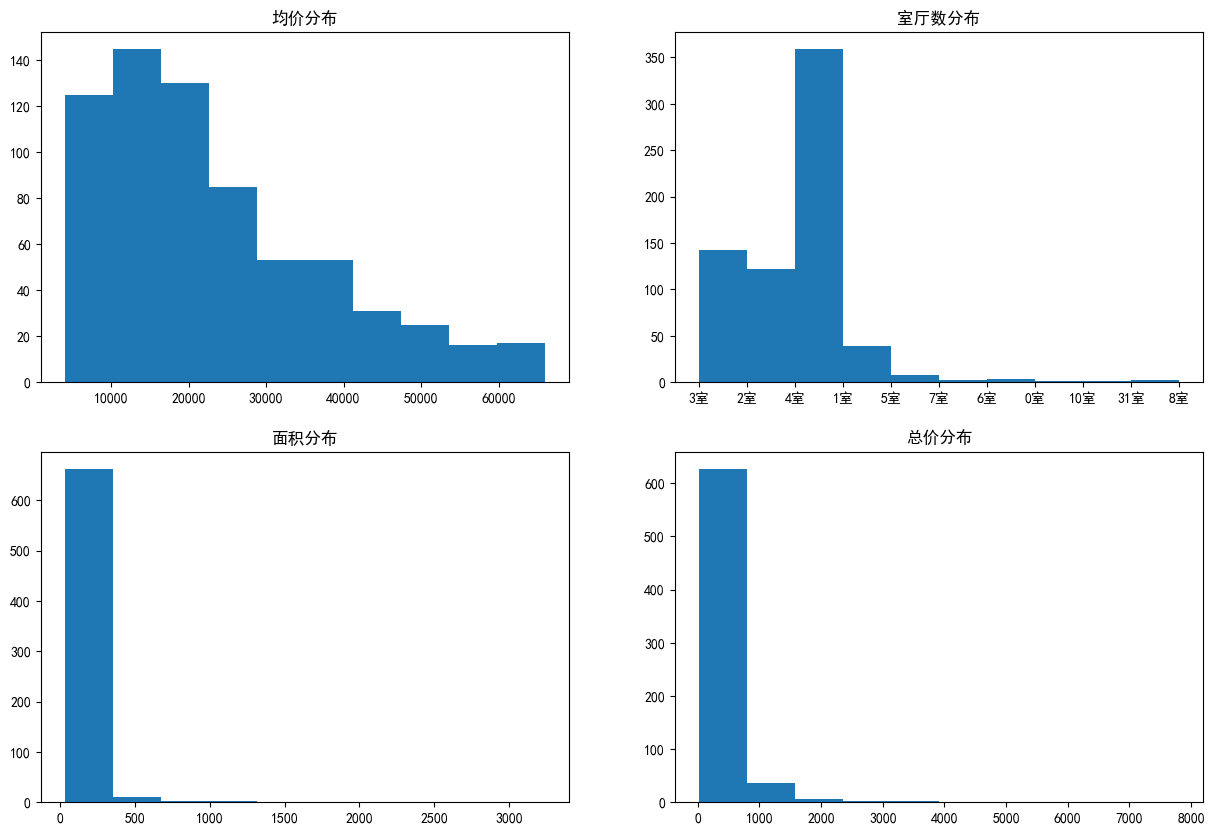

In [38]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.hist(data['均价/平方米每元'])
plt.title('均价分布')

plt.subplot(2,2,2)
plt.hist(data['室厅数'])
plt.title('室厅数分布')

plt.subplot(2,2,3)
plt.hist(data['面积'])
plt.title('面积分布')

plt.subplot(2,2,4)
plt.hist(data['总价'])
plt.title('总价分布')

plt.show()

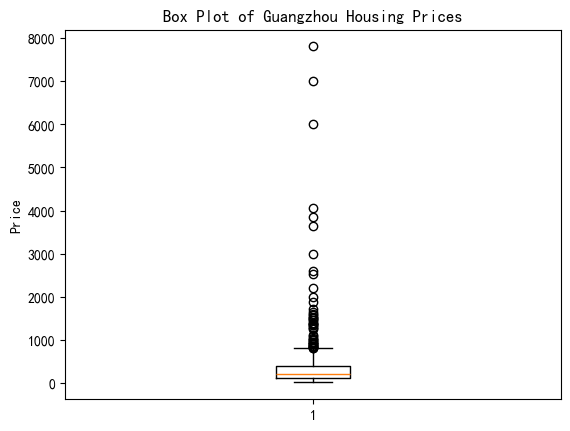

In [39]:
prices=data['总价']

plt.boxplot(prices)
plt.title('Box Plot of Guangzhou Housing Prices')
plt.ylabel('Price')
plt.show()

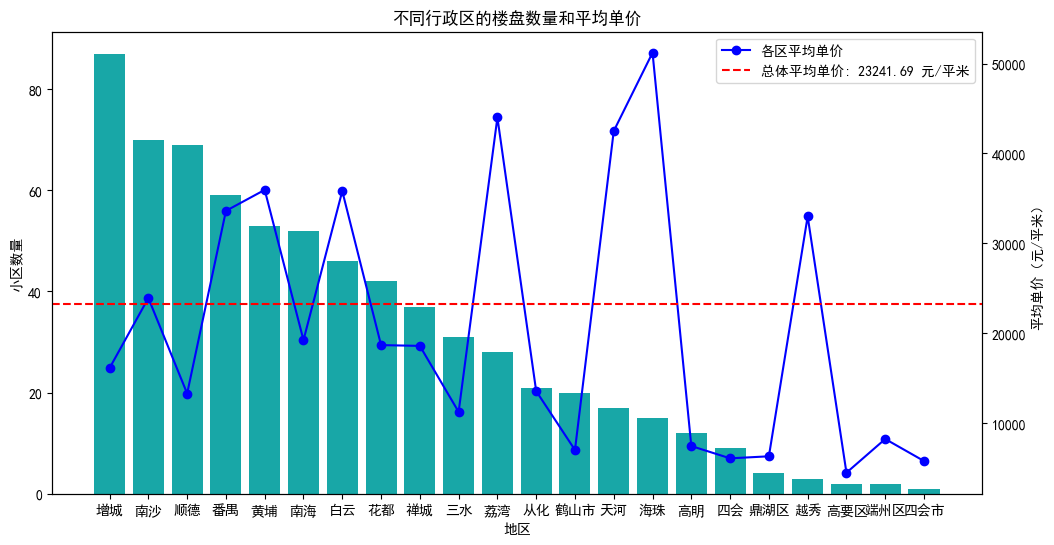

In [40]:
# 计算各地区的小区数量，并按降序排列
region_order = data['地区'].value_counts().index
# print(region_order)

# 计算各行政区的平均单价，按新的顺序对平均单价排序
average_price1 = data.groupby('地区')['均价/平方米每元'].mean()
average_price1 = average_price1.reindex(region_order)
# print(average_price1)

# 计算总体平均单价
overall_average_price = data['均价/平方米每元'].mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

# 按降序排列绘制小区数量的柱状图
sns.countplot(data=data, x='地区', order=region_order, ax=ax1, color='c')
ax1.set_xlabel('地区')
ax1.set_ylabel('小区数量')
ax1.tick_params(axis='x')

# 创建第二个坐标轴，用于绘制各个行政区的单价折线图
ax2 = ax1.twinx()
ax2.plot(average_price1.index, average_price1.values, color='b', marker='o', linestyle='-',label='各区平均单价')
ax2.set_ylabel('平均单价（元/平米）')

# 标出总体平均单价
ax2.axhline(overall_average_price, color='r', linestyle='--', label=f'总体平均单价: {overall_average_price:.2f} 元/平米')
ax2.legend(loc='upper right')

plt.title('不同行政区的楼盘数量和平均单价')
plt.show()

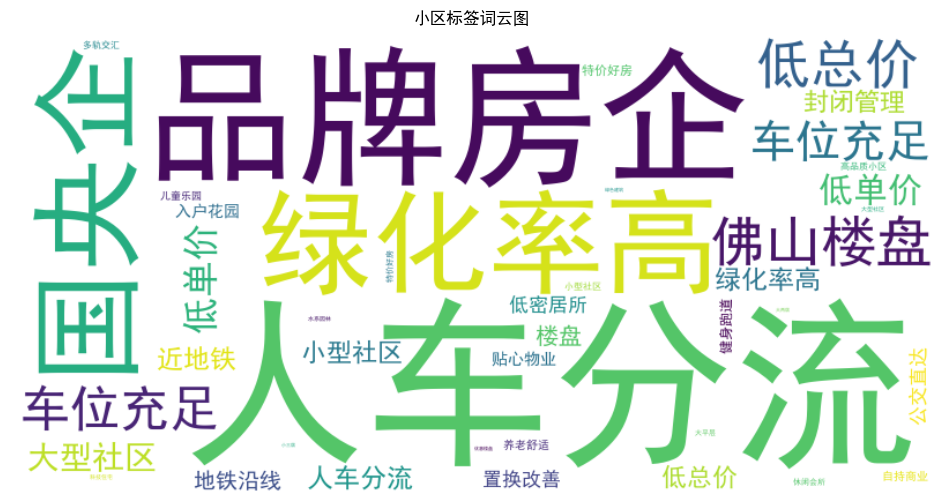

In [ ]:
# 生成词云图,在本地运行时候font_path替换成本地字体
wordcloud = WordCloud(font_path='c:\windows\fonts\simhei.ttf',background_color='white', width=800, height=400).generate_from_frequencies(tag_counts)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('小区标签词云图')
plt.show()

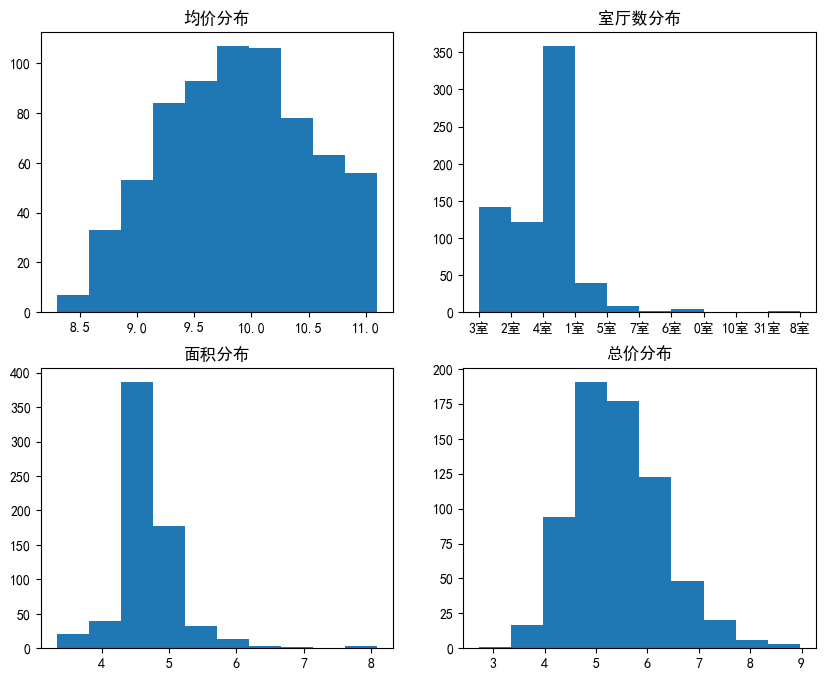

In [43]:
# 通过以上的描述分析可知【均价，总价，面积】呈现偏态分布
# 进行对数变换
data['对数均价/平方米每元'] = np.log(data['均价/平方米每元'])
data['对数总价'] = np.log(data['总价'])
data['对数面积'] = np.log(data['面积'])

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.hist(data['对数均价/平方米每元'])
plt.title('均价分布')

plt.subplot(2,2,2)
plt.hist(data['室厅数'])
plt.title('室厅数分布')

plt.subplot(2,2,3)
plt.hist(data['对数面积'])
plt.title('面积分布')

plt.subplot(2,2,4)
plt.hist(data['对数总价'])
plt.title('总价分布')

plt.show()